In [1]:
import pypsa
import pandas as pd

In [2]:
# Create network
network = pypsa.Network()
hours_in_2018=pd.date_range('2017-06-01T00:00Z','2017-07-01T00:00Z',freq='H') #'2017-12-31T23:00Z'
network.set_snapshots(hours_in_2018)

network.add("Bus","electricity bus")

In [3]:
network.snapshots

DatetimeIndex(['2017-06-01 00:00:00+00:00', '2017-06-01 01:00:00+00:00',
               '2017-06-01 02:00:00+00:00', '2017-06-01 03:00:00+00:00',
               '2017-06-01 04:00:00+00:00', '2017-06-01 05:00:00+00:00',
               '2017-06-01 06:00:00+00:00', '2017-06-01 07:00:00+00:00',
               '2017-06-01 08:00:00+00:00', '2017-06-01 09:00:00+00:00',
               ...
               '2017-06-30 15:00:00+00:00', '2017-06-30 16:00:00+00:00',
               '2017-06-30 17:00:00+00:00', '2017-06-30 18:00:00+00:00',
               '2017-06-30 19:00:00+00:00', '2017-06-30 20:00:00+00:00',
               '2017-06-30 21:00:00+00:00', '2017-06-30 22:00:00+00:00',
               '2017-06-30 23:00:00+00:00', '2017-07-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', length=721, freq='H')

In [4]:
# load electricity demand data
df_elec = pd.read_csv('data/Total Load - Day Ahead _ Actual_DK_201701010000-201801010000.csv',sep=',',index_col=0) # in MWh
#df_elec.drop(df_elec.tail(1).index,inplace=True)
df_elec = df_elec[:network.snapshots.size]

In [5]:
# add load to the bus
network.add("Load","load", bus="electricity bus", p_set=df_elec['Actual Total Load [MW] - Denmark (DK)'].tolist())

In [6]:
def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [7]:
network.add("Carrier", "gas", co2_emissions=0.19) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")

In [8]:
# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';',index_col=0)
CF_wind=df_onshorewind['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind=annuity(30,0.07)*910000*(1+0.033) # in €/MW
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000,
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_wind)

In [9]:
# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv',sep=';',index_col=0)
CF_solar=df_solar['ESP'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar=annuity(25,0.07)*425000*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000,
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar)

In [10]:
capital_cost_OCGT=annuity(25,0.07)*560000*(1+0.033) # in €/MW
fuel_cost=21.6 # in €/MWh_th
efficiency=0.39
marginal_cost_OCGT=fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "OCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            p_nom_max=4000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT
           )

In [11]:
network.lopf(network.snapshots, solver_name='gurobi')

INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 1025158115.34072
  Upper bound: 1025158115.34072
  Number of objectives: 1
  Number of constraints: 5769
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9103
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

('ok', 'optimal')

In [12]:
network.generators.p_nom_opt

onshorewind    9273.042875
solar          1187.293873
OCGT           4000.000000
Name: p_nom_opt, dtype: float64

In [13]:
print(network.objective/1000000) #in 10^6 #
print(network.objective/network.loads_t.p.sum()) # €/MWh

1025.15811534072
load    353.436011
dtype: float64


C:\Users\Tim\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


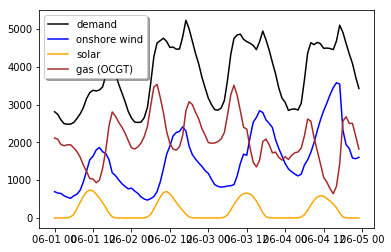

In [14]:
import matplotlib.pyplot as plt

plt.plot(network.loads_t.p['load'][0:96], color='black', label='demand')
plt.plot(network.generators_t.p['onshorewind'][0:96], color='blue', label='onshore wind')
plt.plot(network.generators_t.p['solar'][0:96], color='orange', label='solar')
plt.plot(network.generators_t.p['OCGT'][0:96], color='brown', label='gas (OCGT)')
plt.legend(fancybox=True, shadow=True, loc='best')

Text(0.5, 1.07, 'Electricity mix')

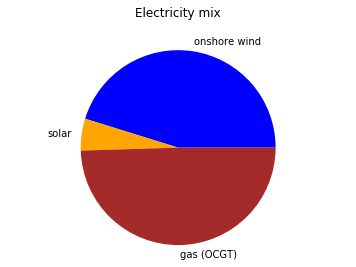

In [15]:
labels = ['onshore wind', 'solar', 'gas (OCGT)' ]
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['solar'].sum(),
         network.generators_t.p['OCGT'].sum()]

colors=['blue', 'orange', 'brown']

plt.pie(sizes, 
        colors=colors, 
        labels=labels, 
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

## Below here is the MGA stuff

In [18]:
import pyomo.environ as pyomo_env

# Saving the value of the old objective function.
old_objective_value = network.model.objective()
print(old_objective_value)

1025158115.3407199


In [19]:
def extra_functionality(network, snapshots,  MGA_slack = 0.05):

    # Identify the nonzero decision variables that should enter the MGA objective function.
    generator_outputs = network.generators_t.p
    nonzero_gen_p = list()
    for gen_p in network.model.generator_p :
        if generator_outputs[gen_p[0]].loc[gen_p[1]] > 0 :
            nonzero_gen_p.append(gen_p)
    
    # Build new MGA objective function.
    MGA_objective = 0
    for gen_p in nonzero_gen_p:
        MGA_objective += network.model.generator_p[gen_p]

    # Add the new MGA objective function to the model.
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)

    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()

    # Add the MGA slack constraint.
    #print('old objective value ',old_objective_value)
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)

In [20]:
# Defining a list for solutions
network.solutions = []
MGA_slack = 0.01
# Loop until a non original solution is found
while True:
    network.lopf(network.snapshots,solver_name='gurobi',extra_functionality=lambda network, snapshots: extra_functionality(network, snapshots, MGA_slack)) 
    # Tjek if the solution is seen before, otherwise add solution to list of solutions
    for i in range(len(network.solutions)):
        if network.generators_t.p.equals(network.solutions[i]):
            break
    else : 
        network.solutions.append(network.generators_t.p)
        continue
    break
            
        

INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2732881.019972904
  Upper bound: 2732881.019972904
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2758324.8510698793
  Upper bound: 2758324.8510698793
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2713585.2540708124
  Upper bound: 2713585.2540708124
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2754205.92228008
  Upper bound: 2754205.92228008
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2716110.674757149
  Upper bound: 2716110.674757149
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Mod

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful
INFO:pypsa.pf:Slack bus for sub-network 0 is electricity bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2757422.2483610483
  Upper bound: 2757422.2483610483
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x2888
  Lower bound: 2713585.2540708124
  Upper bound: 2713585.2540708124
  Number of objectives: 1
  Number of constraints: 5770
  Number of variables: 2888
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 2888
  Number of nonzeros: 9827
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: M

In [21]:
for i in range(len(network.solutions)):
    print('solution ',i+1)
    print(network.solutions[i])

solution  1
                           onshorewind       solar         OCGT
2017-06-01 00:00:00+00:00   693.770721    0.000000  2118.229279
2017-06-01 01:00:00+00:00   656.769616    0.000000  2086.230384
2017-06-01 02:00:00+00:00   647.519340    0.000000  1947.480660
2017-06-01 03:00:00+00:00   582.767406    0.000000  1911.232594
2017-06-01 04:00:00+00:00   545.766301    0.000000  1936.233699
2017-06-01 05:00:00+00:00   518.015472   29.825219  1936.159310
2017-06-01 06:00:00+00:00   582.767406   98.552896  1845.679698
2017-06-01 07:00:00+00:00   629.018787  269.723716  1734.257497
2017-06-01 08:00:00+00:00   730.771826  452.565273  1571.662900
2017-06-01 09:00:00+00:00   952.778457  622.439344  1347.782199
2017-06-01 10:00:00+00:00  1239.537022  753.410956  1168.052022
2017-06-01 11:00:00+00:00  1535.545863  805.280901   977.173235
2017-06-01 12:00:00+00:00  1628.048626  783.236175   968.715199
2017-06-01 13:00:00+00:00  1794.553599  688.573524   877.872876
2017-06-01 14:00:00+00:00  1